# 3. Стационарность и преобразования временных рядов

## Введение

Стационарность — одно из ключевых понятий в анализе временных рядов. Многие классические методы моделирования (ARIMA, VAR, фильтр Калмана) требуют, чтобы данные были стационарными. В этом ноутбуке мы разберем:

- Что такое стационарность и почему она важна
- Типы стационарности
- Методы проверки стационарности
- Преобразования для достижения стационарности
- Практические примеры на реальных данных

## 1. Теоретические основы

### 1.1. Определение стационарности

**Строгая стационарность (Strict Stationarity)**

Временной ряд $\{X_t\}$ называется строго стационарным, если совместное распределение любого подмножества наблюдений $(X_{t_1}, X_{t_2}, ..., X_{t_k})$ не зависит от временного сдвига:

$$P(X_{t_1} \leq x_1, ..., X_{t_k} \leq x_k) = P(X_{t_1+h} \leq x_1, ..., X_{t_k+h} \leq x_k)$$

для любого целого $h$ и любых моментов времени $t_1, ..., t_k$.

**Слабая стационарность (Weak/Covariance Stationarity)**

На практике чаще используется более мягкое определение — стационарность второго порядка или слабая стационарность. Ряд $\{X_t\}$ называется слабо стационарным, если:

1. **Постоянное математическое ожидание**: $E[X_t] = \mu$ для всех $t$
2. **Постоянная дисперсия**: $Var(X_t) = \sigma^2 < \infty$ для всех $t$
3. **Автоковариация зависит только от лага**: $Cov(X_t, X_{t-k}) = \gamma(k)$ для всех $t$ и лага $k$

### 1.2. Почему стационарность важна?

1. **Предсказуемость**: Статистические свойства не меняются во времени, что позволяет делать надежные прогнозы
2. **Математическая обработка**: Многие теоремы (эргодичность, центральная предельная теорема) применимы только к стационарным рядам
3. **Моделирование**: ARMA, ARIMA (после дифференцирования), VAR требуют стационарности
4. **Избежание ложных корреляций**: Нестационарные ряды могут показывать ложные зависимости (spurious regression)

### 1.3. Типы нестационарности

**Тренд-стационарность (Trend-Stationary)**
- Ряд имеет детерминированный тренд
- После удаления тренда ряд становится стационарным
- Пример: $X_t = \alpha + \beta t + \varepsilon_t$, где $\varepsilon_t$ — стационарный процесс

**Разностно-стационарность (Difference-Stationary)**
- Ряд имеет стохастический тренд (единичный корень)
- После взятия разностей ряд становится стационарным
- Пример: $X_t = X_{t-1} + \varepsilon_t$ (случайное блуждание)

**Сезонная нестационарность**
- Сезонные паттерны изменяются во времени
- Требуется сезонное дифференцирование

**Гетероскедастичность**
- Дисперсия изменяется во времени
- Требуются преобразования типа логарифмирования или GARCH-модели

### 1.4. Автокорреляционная функция (ACF)

ACF показывает корреляцию между наблюдениями, разделенными лагом $k$:

$$\rho(k) = \frac{Cov(X_t, X_{t-k})}{\sqrt{Var(X_t)Var(X_{t-k})}} = \frac{\gamma(k)}{\gamma(0)}$$

Для стационарного ряда:
- ACF быстро убывает к нулю
- Для нестационарного ряда: ACF убывает медленно или не убывает вовсе

## 2. Практическая реализация

### 2.1. Подготовка окружения

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Статистические тесты
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings('ignore')

# Настройка визуализации
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 6)

print("Библиотеки успешно загружены!")

Библиотеки успешно загружены!


### 2.2. Генерация примеров временных рядов

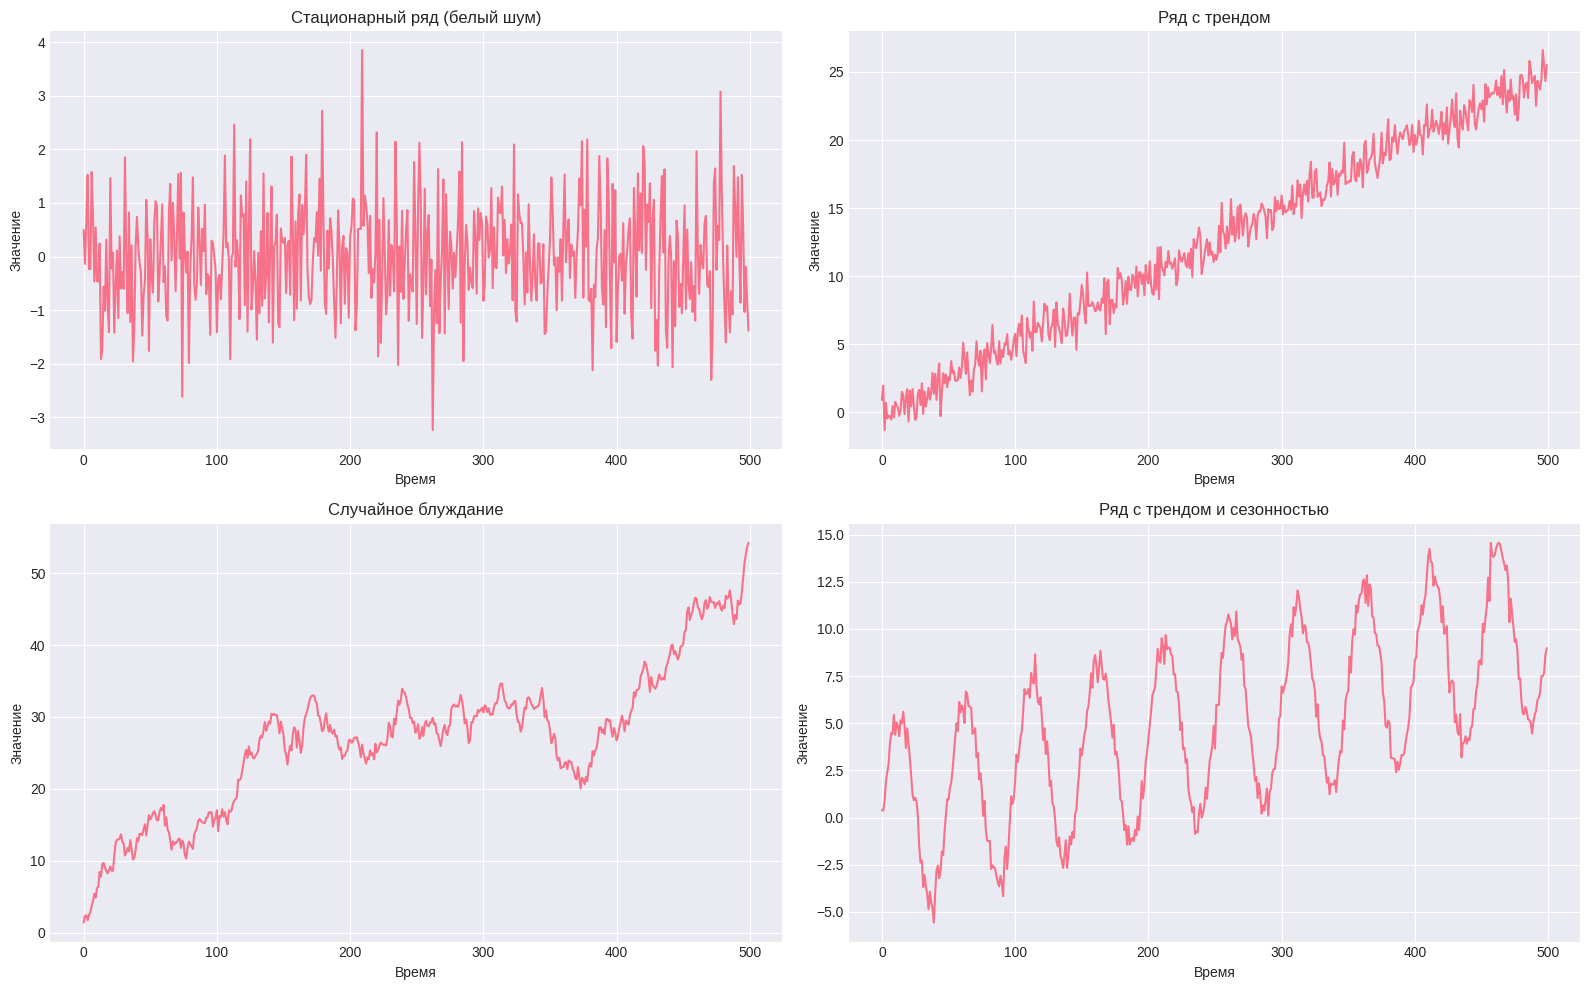

In [2]:
np.random.seed(42)
n = 500
time = np.arange(n)

# 1. Стационарный ряд (белый шум)
stationary = np.random.randn(n)

# 2. Ряд с трендом (тренд-стационарный)
trend_stationary = 0.05 * time + np.random.randn(n)

# 3. Случайное блуждание (разностно-стационарный)
random_walk = np.cumsum(np.random.randn(n))

# 4. Ряд с трендом и сезонностью
trend = 0.02 * time
seasonality = 5 * np.sin(2 * np.pi * time / 50)
trend_seasonal = trend + seasonality + np.random.randn(n) * 0.5

# Создание DataFrame
df = pd.DataFrame({
    'time': time,
    'stationary': stationary,
    'trend_stationary': trend_stationary,
    'random_walk': random_walk,
    'trend_seasonal': trend_seasonal
})

# Визуализация
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

axes[0, 0].plot(df['time'], df['stationary'])
axes[0, 0].set_title('Стационарный ряд (белый шум)')
axes[0, 0].set_xlabel('Время')
axes[0, 0].set_ylabel('Значение')

axes[0, 1].plot(df['time'], df['trend_stationary'])
axes[0, 1].set_title('Ряд с трендом')
axes[0, 1].set_xlabel('Время')
axes[0, 1].set_ylabel('Значение')

axes[1, 0].plot(df['time'], df['random_walk'])
axes[1, 0].set_title('Случайное блуждание')
axes[1, 0].set_xlabel('Время')
axes[1, 0].set_ylabel('Значение')

axes[1, 1].plot(df['time'], df['trend_seasonal'])
axes[1, 1].set_title('Ряд с трендом и сезонностью')
axes[1, 1].set_xlabel('Время')
axes[1, 1].set_ylabel('Значение')

plt.tight_layout()
plt.show()

## 3. Методы проверки стационарности

### 3.1. Визуальный анализ

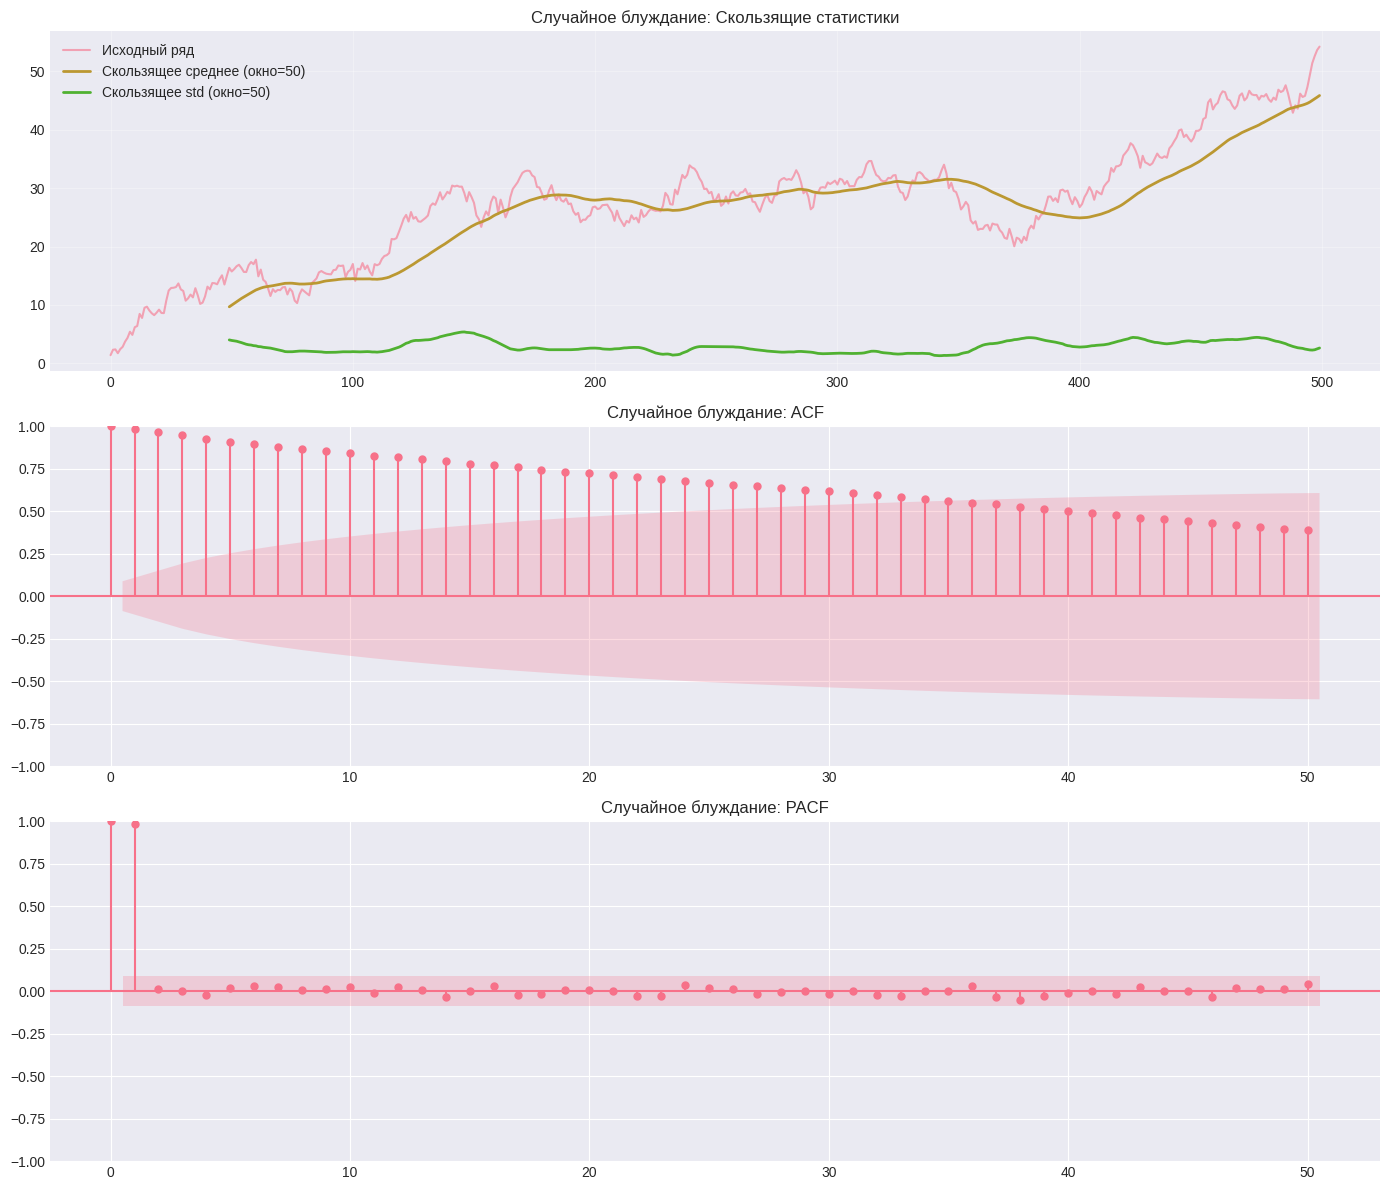

In [3]:
def visual_stationarity_check(series, title='Временной ряд'):
    """
    Визуальная проверка стационарности:
    - График ряда
    - Скользящее среднее и стандартное отклонение
    - ACF и PACF
    """
    fig, axes = plt.subplots(3, 1, figsize=(14, 12))
    
    # 1. График ряда со скользящими статистиками
    rolling_mean = series.rolling(window=50).mean()
    rolling_std = series.rolling(window=50).std()
    
    axes[0].plot(series, label='Исходный ряд', alpha=0.6)
    axes[0].plot(rolling_mean, label='Скользящее среднее (окно=50)', linewidth=2)
    axes[0].plot(rolling_std, label='Скользящее std (окно=50)', linewidth=2)
    axes[0].set_title(f'{title}: Скользящие статистики')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # 2. ACF
    plot_acf(series, lags=50, ax=axes[1], alpha=0.05)
    axes[1].set_title(f'{title}: ACF')
    
    # 3. PACF
    plot_pacf(series, lags=50, ax=axes[2], alpha=0.05, method='ywm')
    axes[2].set_title(f'{title}: PACF')
    
    plt.tight_layout()
    plt.show()

# Проверка для случайного блуждания
visual_stationarity_check(df['random_walk'], title='Случайное блуждание')

### 3.2. Augmented Dickey-Fuller Test (ADF)

ADF-тест проверяет наличие единичного корня в временном ряду.

**Гипотезы:**
- $H_0$: Ряд имеет единичный корень (нестационарен)
- $H_1$: Ряд не имеет единичного корня (стационарен)

**Интерпретация:**
- Если p-value < 0.05: отвергаем $H_0$, ряд стационарен
- Если p-value ≥ 0.05: не можем отвергнуть $H_0$, ряд нестационарен

In [4]:
def adf_test(series, name='Ряд'):
    """
    Выполнение и интерпретация ADF-теста
    """
    result = adfuller(series, autolag='AIC')
    
    print(f'\n{"="*60}')
    print(f'ADF-тест для: {name}')
    print(f'{"="*60}')
    print(f'ADF Statistic: {result[0]:.6f}')
    print(f'p-value: {result[1]:.6f}')
    print(f'Использовано лагов: {result[2]}')
    print(f'Количество наблюдений: {result[3]}')
    print('\nКритические значения:')
    for key, value in result[4].items():
        print(f'   {key}: {value:.3f}')
    
    if result[1] <= 0.05:
        print(f'\n✅ Вывод: Ряд СТАЦИОНАРЕН (p-value = {result[1]:.6f} ≤ 0.05)')
    else:
        print(f'\n❌ Вывод: Ряд НЕСТАЦИОНАРЕН (p-value = {result[1]:.6f} > 0.05)')
    
    return result

# Проверка всех рядов
for col in ['stationary', 'trend_stationary', 'random_walk', 'trend_seasonal']:
    adf_test(df[col], name=col)


ADF-тест для: stationary
ADF Statistic: -22.343815
p-value: 0.000000
Использовано лагов: 0
Количество наблюдений: 499

Критические значения:
   1%: -3.444
   5%: -2.867
   10%: -2.570

✅ Вывод: Ряд СТАЦИОНАРЕН (p-value = 0.000000 ≤ 0.05)

ADF-тест для: trend_stationary
ADF Statistic: -0.379965
p-value: 0.913391
Использовано лагов: 18
Количество наблюдений: 481

Критические значения:
   1%: -3.444
   5%: -2.868
   10%: -2.570

❌ Вывод: Ряд НЕСТАЦИОНАРЕН (p-value = 0.913391 > 0.05)

ADF-тест для: random_walk
ADF Statistic: -0.919979
p-value: 0.781322
Использовано лагов: 0
Количество наблюдений: 499

Критические значения:
   1%: -3.444
   5%: -2.867
   10%: -2.570

❌ Вывод: Ряд НЕСТАЦИОНАРЕН (p-value = 0.781322 > 0.05)

ADF-тест для: trend_seasonal
ADF Statistic: -1.732251
p-value: 0.414577
Использовано лагов: 18
Количество наблюдений: 481

Критические значения:
   1%: -3.444
   5%: -2.868
   10%: -2.570

❌ Вывод: Ряд НЕСТАЦИОНАРЕН (p-value = 0.414577 > 0.05)


### 3.3. KPSS Test (Kwiatkowski-Phillips-Schmidt-Shin)

KPSS-тест — это дополнительный тест, который проверяет стационарность с противоположной гипотезой.

**Гипотезы:**
- $H_0$: Ряд стационарен (тренд-стационарен)
- $H_1$: Ряд имеет единичный корень (нестационарен)

**Интерпретация:**
- Если p-value < 0.05: отвергаем $H_0$, ряд нестационарен
- Если p-value ≥ 0.05: не можем отвергнуть $H_0$, ряд стационарен

**Совместное использование ADF и KPSS:**

| ADF (p-value) | KPSS (p-value) | Интерпретация |
|---------------|----------------|---------------|
| < 0.05 | > 0.05 | Стационарен |
| > 0.05 | < 0.05 | Нестационарен |
| > 0.05 | > 0.05 | Тренд-стационарен |
| < 0.05 | < 0.05 | Неоднозначно, нужен дополнительный анализ |

In [5]:
def kpss_test(series, name='Ряд'):
    """
    Выполнение и интерпретация KPSS-теста
    """
    result = kpss(series, regression='ct', nlags='auto')
    
    print(f'\n{"="*60}')
    print(f'KPSS-тест для: {name}')
    print(f'{"="*60}')
    print(f'KPSS Statistic: {result[0]:.6f}')
    print(f'p-value: {result[1]:.6f}')
    print(f'Использовано лагов: {result[2]}')
    print('\nКритические значения:')
    for key, value in result[3].items():
        print(f'   {key}: {value:.3f}')
    
    if result[1] >= 0.05:
        print(f'\n✅ Вывод: Ряд СТАЦИОНАРЕН (p-value = {result[1]:.6f} ≥ 0.05)')
    else:
        print(f'\n❌ Вывод: Ряд НЕСТАЦИОНАРЕН (p-value = {result[1]:.6f} < 0.05)')
    
    return result

# Проверка для случайного блуждания
kpss_test(df['random_walk'], name='random_walk')


KPSS-тест для: random_walk
KPSS Statistic: 0.350128
p-value: 0.010000
Использовано лагов: 12

Критические значения:
   10%: 0.119
   5%: 0.146
   2.5%: 0.176
   1%: 0.216

❌ Вывод: Ряд НЕСТАЦИОНАРЕН (p-value = 0.010000 < 0.05)


(np.float64(0.350127771561646),
 np.float64(0.01),
 12,
 {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216})

## 4. Преобразования для достижения стационарности

### 4.1. Дифференцирование (Differencing)

**Первая разность:**
$$\nabla X_t = X_t - X_{t-1}$$

**Вторая разность:**
$$\nabla^2 X_t = \nabla X_t - \nabla X_{t-1} = X_t - 2X_{t-1} + X_{t-2}$$

**Сезонное дифференцирование (период s):**
$$\nabla_s X_t = X_t - X_{t-s}$$

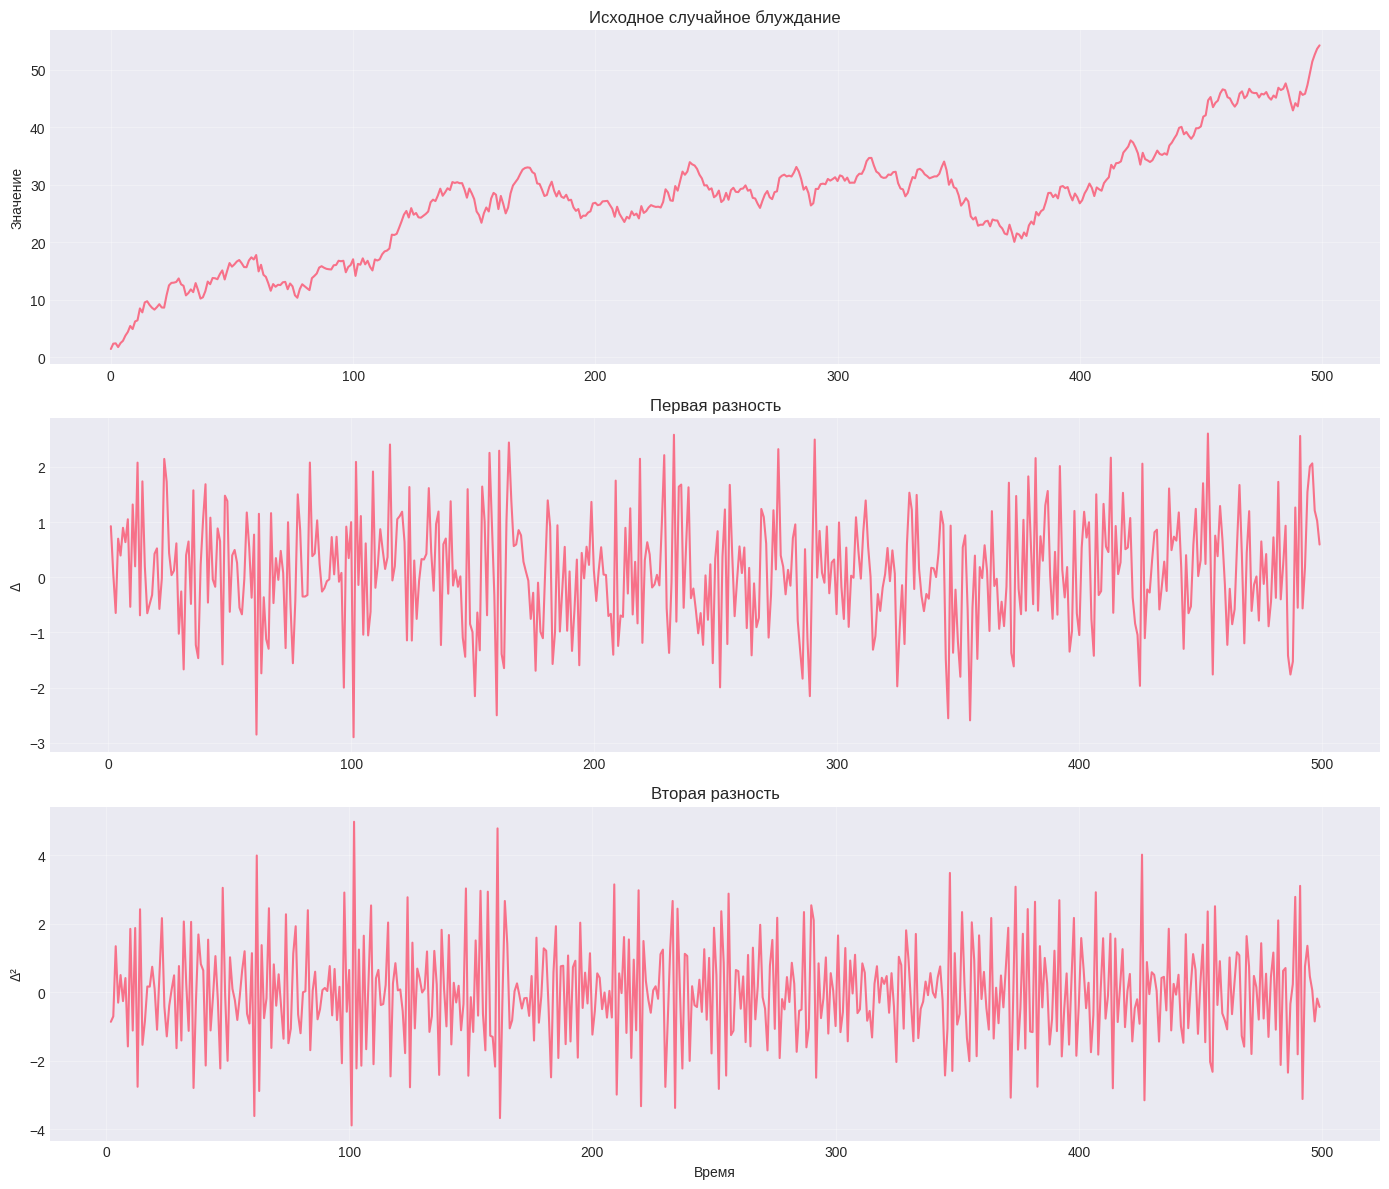


ПРОВЕРКА СТАЦИОНАРНОСТИ ПОСЛЕ ДИФФЕРЕНЦИРОВАНИЯ

ADF-тест для: Первая разность
ADF Statistic: -22.846189
p-value: 0.000000
Использовано лагов: 0
Количество наблюдений: 498

Критические значения:
   1%: -3.444
   5%: -2.867
   10%: -2.570

✅ Вывод: Ряд СТАЦИОНАРЕН (p-value = 0.000000 ≤ 0.05)

KPSS-тест для: Первая разность
KPSS Statistic: 0.136647
p-value: 0.067320
Использовано лагов: 4

Критические значения:
   10%: 0.119
   5%: 0.146
   2.5%: 0.176
   1%: 0.216

✅ Вывод: Ряд СТАЦИОНАРЕН (p-value = 0.067320 ≥ 0.05)


(np.float64(0.1366470630960974),
 np.float64(0.06732025352574555),
 4,
 {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216})

In [6]:
# Применение дифференцирования к случайному блужданию
df['random_walk_diff1'] = df['random_walk'].diff()
df['random_walk_diff2'] = df['random_walk'].diff().diff()

fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# Исходный ряд
axes[0].plot(df['time'], df['random_walk'])
axes[0].set_title('Исходное случайное блуждание')
axes[0].set_ylabel('Значение')
axes[0].grid(True, alpha=0.3)

# Первая разность
axes[1].plot(df['time'], df['random_walk_diff1'])
axes[1].set_title('Первая разность')
axes[1].set_ylabel('Δ')
axes[1].grid(True, alpha=0.3)

# Вторая разность
axes[2].plot(df['time'], df['random_walk_diff2'])
axes[2].set_title('Вторая разность')
axes[2].set_xlabel('Время')
axes[2].set_ylabel('Δ²')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Проверка стационарности после дифференцирования
print("\n" + "="*60)
print("ПРОВЕРКА СТАЦИОНАРНОСТИ ПОСЛЕ ДИФФЕРЕНЦИРОВАНИЯ")
print("="*60)
adf_test(df['random_walk_diff1'].dropna(), name='Первая разность')
kpss_test(df['random_walk_diff1'].dropna(), name='Первая разность')

### 4.2. Удаление тренда (Detrending)

**Методы:**
1. Вычитание линейного тренда
2. Вычитание скользящего среднего
3. Декомпозиция (decomposition)

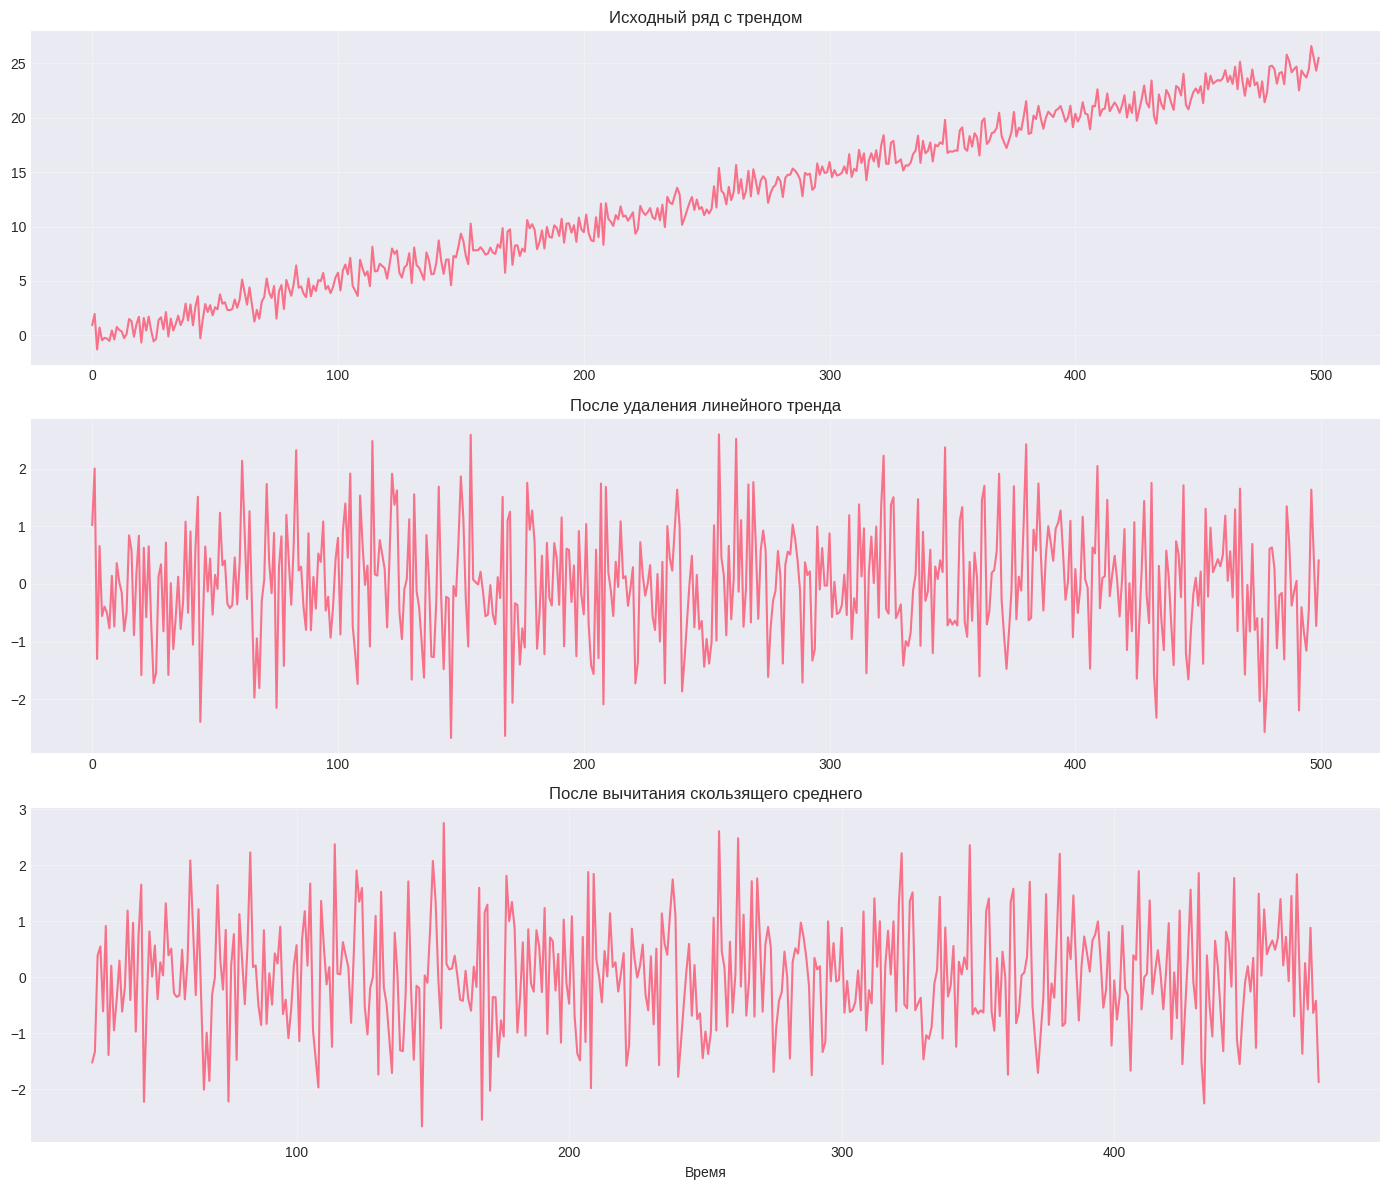


ADF-тест для: Detrended (linear)
ADF Statistic: -22.641720
p-value: 0.000000
Использовано лагов: 0
Количество наблюдений: 499

Критические значения:
   1%: -3.444
   5%: -2.867
   10%: -2.570

✅ Вывод: Ряд СТАЦИОНАРЕН (p-value = 0.000000 ≤ 0.05)


(np.float64(-22.641720256298683),
 0.0,
 0,
 499,
 {'1%': np.float64(-3.4435228622952065),
  '5%': np.float64(-2.867349510566146),
  '10%': np.float64(-2.569864247011056)},
 np.float64(1350.094050372832))

In [7]:
from scipy import signal

# Метод 1: Вычитание линейного тренда
detrended_linear = signal.detrend(df['trend_stationary'])

# Метод 2: Вычитание скользящего среднего
rolling_mean = df['trend_stationary'].rolling(window=50, center=True).mean()
detrended_ma = df['trend_stationary'] - rolling_mean

# Визуализация
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

axes[0].plot(df['time'], df['trend_stationary'])
axes[0].set_title('Исходный ряд с трендом')
axes[0].grid(True, alpha=0.3)

axes[1].plot(df['time'], detrended_linear)
axes[1].set_title('После удаления линейного тренда')
axes[1].grid(True, alpha=0.3)

axes[2].plot(df['time'], detrended_ma)
axes[2].set_title('После вычитания скользящего среднего')
axes[2].set_xlabel('Время')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Проверка стационарности
adf_test(detrended_linear, name='Detrended (linear)')

### 4.3. Логарифмирование и степенные преобразования

Используются для стабилизации дисперсии (устранения гетероскедастичности).

**Преобразование Бокса-Кокса:**

$$y_t^{(\lambda)} = \begin{cases}
\frac{y_t^\lambda - 1}{\lambda}, & \lambda \neq 0 \\
\ln(y_t), & \lambda = 0
\end{cases}$$

где $\lambda$ — параметр преобразования.

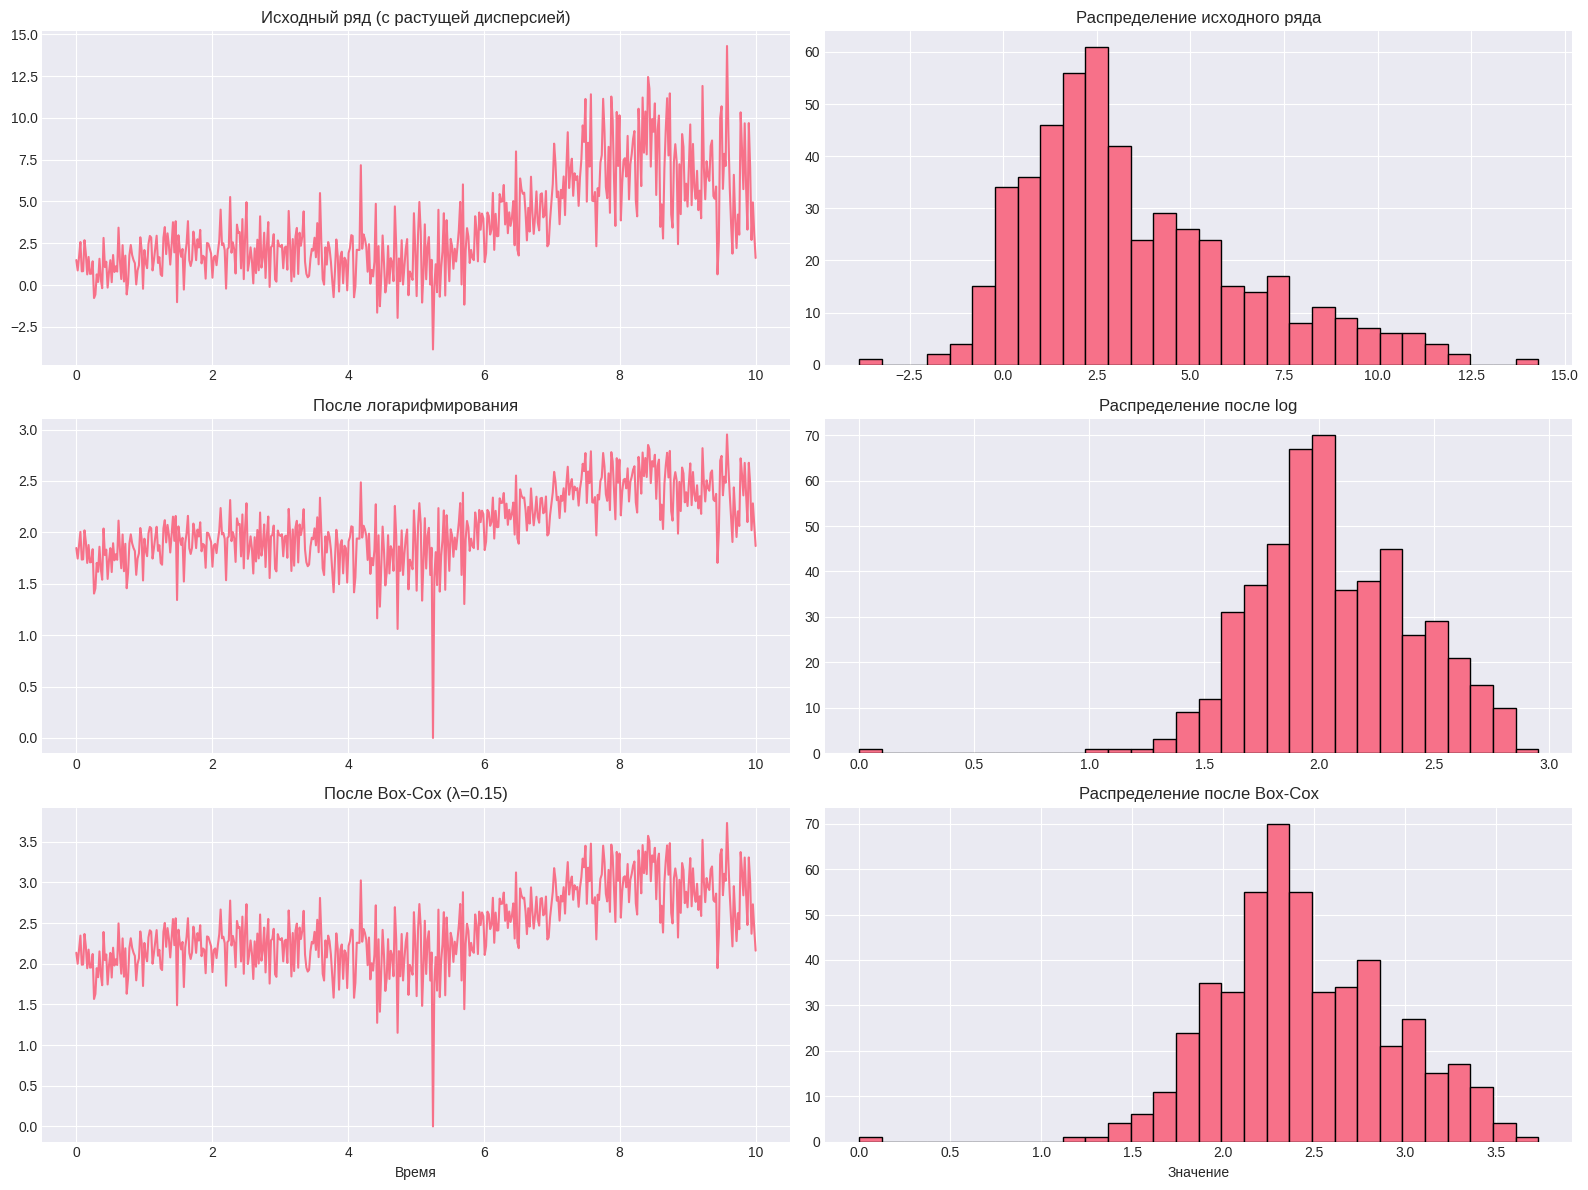

Оптимальный параметр λ для Box-Cox: 0.1527


In [8]:
# Генерация ряда с растущей дисперсией
np.random.seed(42)
t = np.linspace(0, 10, 500)
heteroscedastic = np.exp(0.2 * t) * (1 + 0.5 * np.sin(t)) + np.random.randn(500) * np.exp(0.1 * t)

# Логарифмическое преобразование
log_transformed = np.log(heteroscedastic + abs(heteroscedastic.min()) + 1)

# Преобразование Бокса-Кокса
from scipy.stats import boxcox
boxcox_transformed, lambda_param = boxcox(heteroscedastic + abs(heteroscedastic.min()) + 1)

# Визуализация
fig, axes = plt.subplots(3, 2, figsize=(16, 12))

# Исходный ряд
axes[0, 0].plot(t, heteroscedastic)
axes[0, 0].set_title('Исходный ряд (с растущей дисперсией)')
axes[0, 1].hist(heteroscedastic, bins=30, edgecolor='black')
axes[0, 1].set_title('Распределение исходного ряда')

# После логарифмирования
axes[1, 0].plot(t, log_transformed)
axes[1, 0].set_title('После логарифмирования')
axes[1, 1].hist(log_transformed, bins=30, edgecolor='black')
axes[1, 1].set_title('Распределение после log')

# После Box-Cox
axes[2, 0].plot(t, boxcox_transformed)
axes[2, 0].set_title(f'После Box-Cox (λ={lambda_param:.2f})')
axes[2, 0].set_xlabel('Время')
axes[2, 1].hist(boxcox_transformed, bins=30, edgecolor='black')
axes[2, 1].set_title('Распределение после Box-Cox')
axes[2, 1].set_xlabel('Значение')

plt.tight_layout()
plt.show()

print(f"Оптимальный параметр λ для Box-Cox: {lambda_param:.4f}")

### 4.4. Сезонное дифференцирование

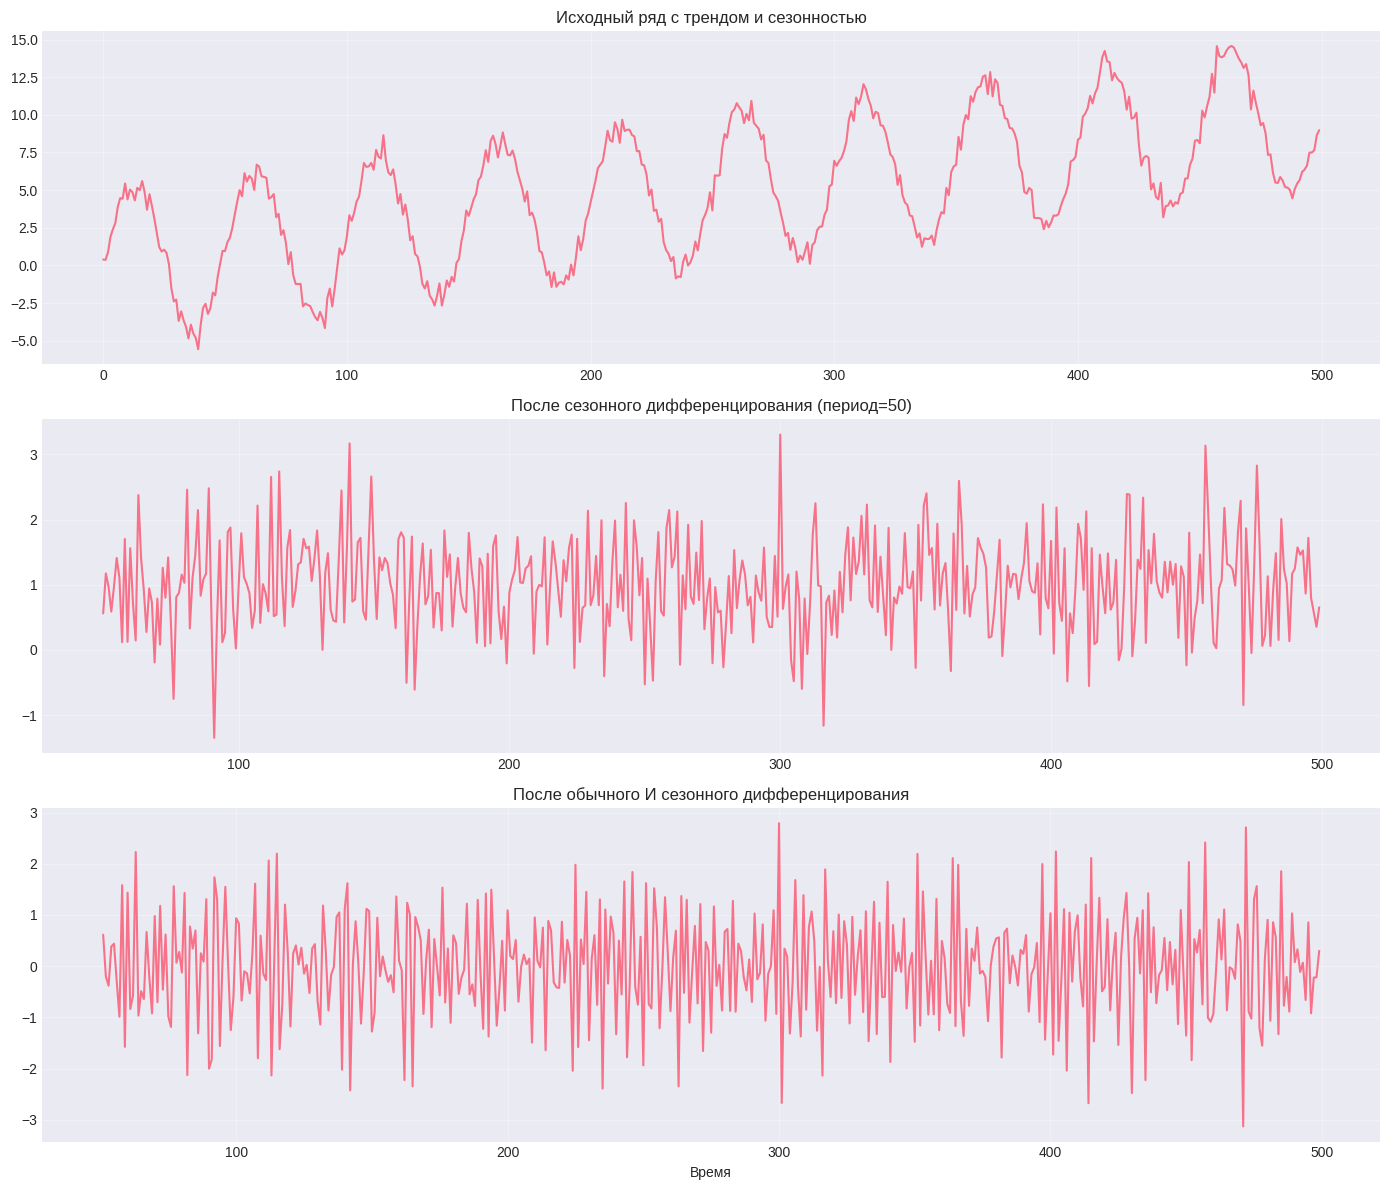


ADF-тест для: После обоих дифференцирований
ADF Statistic: -9.177783
p-value: 0.000000
Использовано лагов: 17
Количество наблюдений: 431

Критические значения:
   1%: -3.446
   5%: -2.868
   10%: -2.570

✅ Вывод: Ряд СТАЦИОНАРЕН (p-value = 0.000000 ≤ 0.05)


(np.float64(-9.177783472139263),
 np.float64(2.29513132567061e-15),
 17,
 431,
 {'1%': np.float64(-3.445613745346461),
  '5%': np.float64(-2.868269325317112),
  '10%': np.float64(-2.5703544951308404)},
 np.float64(972.1502655193112))

In [9]:
# Сезонное дифференцирование для ряда с сезонностью
seasonal_period = 50  # период сезонности в нашем синтетическом ряду

df['trend_seasonal_diff_seasonal'] = df['trend_seasonal'].diff(seasonal_period)
df['trend_seasonal_diff_both'] = df['trend_seasonal'].diff().diff(seasonal_period)

fig, axes = plt.subplots(3, 1, figsize=(14, 12))

axes[0].plot(df['time'], df['trend_seasonal'])
axes[0].set_title('Исходный ряд с трендом и сезонностью')
axes[0].grid(True, alpha=0.3)

axes[1].plot(df['time'], df['trend_seasonal_diff_seasonal'])
axes[1].set_title(f'После сезонного дифференцирования (период={seasonal_period})')
axes[1].grid(True, alpha=0.3)

axes[2].plot(df['time'], df['trend_seasonal_diff_both'])
axes[2].set_title('После обычного И сезонного дифференцирования')
axes[2].set_xlabel('Время')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Проверка стационарности
adf_test(df['trend_seasonal_diff_both'].dropna(), name='После обоих дифференцирований')

## 5. Практические рекомендации

### 5.1. Алгоритм проверки и достижения стационарности

1. **Визуальный анализ**
   - Построить график ряда
   - Оценить наличие тренда, сезонности, изменения дисперсии
   - Построить ACF/PACF

2. **Статистические тесты**
   - Провести ADF-тест
   - Провести KPSS-тест
   - Интерпретировать результаты совместно

3. **Выбор преобразования**
   - Если есть растущая дисперсия → логарифмирование или Box-Cox
   - Если есть тренд:
     - Детерминированный → вычитание тренда
     - Стохастический → дифференцирование
   - Если есть сезонность → сезонное дифференцирование

4. **Проверка результата**
   - Повторить статистические тесты
   - Проверить ACF/PACF
   - При необходимости применить дополнительные преобразования

### 5.2. Сколько раз дифференцировать?

**Избыточное дифференцирование (over-differencing):**
- Приводит к ухудшению прогнозов
- Вносит дополнительную автокорреляцию

**Правило:**
- Обычно достаточно d = 1 или d = 2
- Для сезонных рядов: D = 1 (сезонное дифференцирование)
- Проверяйте стационарность после каждого шага

### 5.3. Важные замечания

1. **Не все модели требуют стационарности**
   - Нейронные сети могут работать с нестационарными рядами
   - Некоторые модели ML адаптивны к нестационарности

2. **Преобразования должны быть обратимы**
   - Сохраняйте параметры преобразований
   - Применяйте обратные преобразования к прогнозам

3. **Интерпретация после преобразований**
   - Логарифмирование → изменения в процентах
   - Дифференцирование → изменения (приросты)
   - Box-Cox → сложная интерпретация

## 6. Задания для самостоятельной работы

### Задание 1: Базовый уровень

Загрузите реальный временной ряд (например, цены акций, курсы валют, температуру) и:

1. Постройте график ряда
2. Выполните визуальный анализ со скользящими статистиками
3. Проведите ADF-тест и KPSS-тест
4. Интерпретируйте результаты: стационарен ли ряд?
5. Постройте ACF и PACF графики

In [10]:
# TODO: Задание 1
# Загрузите свои данные и выполните анализ

pass

### Задание 2: Продвинутый уровень

Для ряда из Задания 1 (если он оказался нестационарным):

1. Определите тип нестационарности (тренд, сезонность, изменение дисперсии)
2. Примените подходящие преобразования:
   - При необходимости: логарифмирование или Box-Cox
   - Дифференцирование (обычное и/или сезонное)
3. После каждого преобразования проверяйте стационарность
4. Найдите минимальный набор преобразований, делающих ряд стационарным
5. Визуализируйте исходный ряд и все промежуточные преобразования
6. Сравните ACF/PACF до и после преобразований

In [11]:
# TODO: Задание 2
# Примените преобразования для достижения стационарности

pass

### Задание 3: Исследовательский уровень

Проведите комплексное исследование:

1. Найдите 3-5 различных временных рядов из разных областей (финансы, метеорология, экономика и т.д.)
2. Для каждого ряда:
   - Проведите полный анализ стационарности
   - Примените различные методы преобразования
   - Сравните эффективность разных подходов
3. Создайте сводную таблицу с результатами тестов для всех рядов
4. Постройте сравнительные визуализации
5. Напишите выводы:
   - Какие типы нестационарности наиболее часто встречаются?
   - Какие преобразования наиболее эффективны?
   - Есть ли связь между типом данных и типом нестационарности?

**Дополнительно (необязательно):**
- Реализуйте автоматическую процедуру подбора преобразований
- Сравните результаты ADF и KPSS тестов: как часто они дают согласованные результаты?

In [12]:
# TODO: Задание 3
# Комплексное исследование стационарности

pass

## 7. Контрольные вопросы

1. В чем разница между строгой и слабой стационарностью?
2. Почему стационарность важна для моделирования временных рядов?
3. Что такое единичный корень и как он связан со стационарностью?
4. В чем разница между тренд-стационарностью и разностно-стационарностью?
5. Как интерпретировать результаты ADF-теста?
6. В чем отличие гипотез ADF и KPSS тестов? Почему полезно использовать оба?
7. Когда следует применять дифференцирование, а когда — вычитание тренда?
8. Что такое избыточное дифференцирование и почему оно вредно?
9. Для чего используется преобразование Бокса-Кокса?
10. Как выглядит ACF стационарного и нестационарного ряда?
11. Что такое сезонное дифференцирование и когда его применять?
12. Почему важно применять обратные преобразования к прогнозам?

## 8. Дополнительные материалы

**Литература:**
- Hamilton, J.D. (1994). *Time Series Analysis*. Princeton University Press.
- Brockwell, P.J., Davis, R.A. (2016). *Introduction to Time Series and Forecasting*. Springer.
- Hyndman, R.J., Athanasopoulos, G. (2021). *Forecasting: Principles and Practice* (3rd ed). OTexts. https://otexts.com/fpp3/

**Онлайн-ресурсы:**
- Statsmodels Documentation: https://www.statsmodels.org/stable/index.html
- "Stationarity and differencing" by Rob Hyndman: https://otexts.com/fpp3/stationarity.html
- "Unit Root Tests" by Dave Giles: http://davegiles.blogspot.com/

**Датасеты для практики:**
- Yahoo Finance (yfinance): финансовые данные
- FRED (Federal Reserve Economic Data): экономические показатели
- Kaggle Time Series datasets: https://www.kaggle.com/datasets?tags=13207-Time+Series